In [1]:
import sys
import re
import nltk
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import classification_report, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from PIL import Image

In [2]:
dev_path = '../dataset/development.csv'
eva_path = '../dataset/evaluation.csv'

In [3]:
development_ds = pd.read_csv(dev_path, low_memory=True)
ev_ds = pd.read_csv(eva_path)

dss = [development_ds, ev_ds]
dev_ds = pd.concat(dss, ignore_index=True)
dev_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299993 entries, 0 to 299992
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sentiment  224994 non-null  float64
 1   ids        299993 non-null  int64  
 2   date       299993 non-null  object 
 3   flag       299993 non-null  object 
 4   user       299993 non-null  object 
 5   text       299993 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 13.7+ MB


In [4]:
development_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


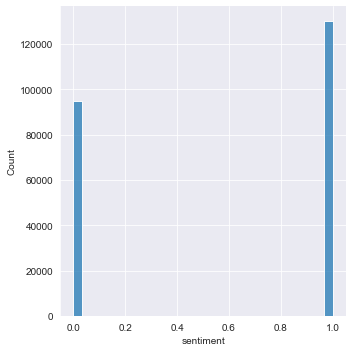

In [5]:
sns.displot(development_ds['sentiment']).savefig('./imgs/dev_distirbution.png')

In [6]:
ps = development_ds[development_ds['sentiment'] == 1]
ns = development_ds[development_ds['sentiment'] == 0]

print(len(ps))
print(len(ns))
print((len(ps)/len(development_ds)) * 100)
print((len(ns)/len(development_ds)) * 100)

130157
94837
57.849098198174175
42.150901801825825


In [9]:
dev_ds.nunique()


sentiment         2
ids          299495
date         240397
flag              1
user          10647
text         297101
dtype: int64

In [10]:
text = dev_ds.text.unique()

In [11]:
text[:10]

array(["@MissBianca76 Yes, talking helps a lot.. going through it, there's no judgment... most sentences end with &quot;you know what I mean&quot; ",
       'SUNSHINE. livingg itttt. imma lie on the grass listening to oasis reading  burnt already',
       '@PleaseBeMine Something for your iphone ',
       "@GabrielSaporta couldn't get in to the after party. ",
       '@bradiewebbstack awww is andy being mean again?  Now i want maccas. ',
       "I'm getting so anxious about tomorrow. Help? ",
       '@nocturnalie The Doctors and Masters are screwed then! ',
       '@manxmidge barely been used. ',
       "hahah it can't work on livejournal ",
       '@socaldavel Ugh! Sorry ur sick!  Fresh fruit drinks &amp; Vits E, C, B, Echinacea &amp; Golden Seal. Rest is nice.'],
      dtype=object)

In [12]:
dev_ds.ids.isnull().sum()

0

In [13]:
print(f'Total unique elements for FLAG feature over development dataset: {development_ds.flag.nunique()} '
      f'on a total of {len(development_ds)}')
print(f'Total unique elements for IDS feature over development dataset: {development_ds.ids.nunique()} '
      f'on a total of {len(development_ds)}')

Total unique elements for FLAG feature over development dataset: 1 on a total of 224994
Total unique elements for IDS feature over development dataset: 224716 on a total of 224994


We observe that the ids feature are almost all unique values for all the records and so, being identifiers we drop them
As well the flag feature brings no information being the same for every record

Next we are interested if users between 2 dataframes are the same

In [14]:
ev_usrs = ev_ds.user.unique()
dev_usrs = development_ds.user.unique()

print(f'eval_users len: {len(ev_usrs)}\ndev_users len: {len(dev_usrs)}')
union = set.union(set(ev_usrs), set(dev_usrs))

print(f'intersection between two set of users have lenght: {len(union)}')

eval_users len: 10647
dev_users len: 10647
intersection between two set of users have lenght: 10647


the same users are present in both dataset, so we can merge the two dataset and handle unique categorical
data for the user feature

In [15]:
def encode_users(df):
    probs = pd.DataFrame(df.groupby(['user'])['sentiment'].mean())

    # creating ratio between neg and pos
    probs['neg'] = 1 - probs['sentiment']
    probs['ratio'] = probs['sentiment'] / probs['neg']

    # removing infinite values
    probs['ratio'] = probs.ratio.map(lambda x: 80 if x == np.inf else x )

    enc_prob_ratio = probs.ratio.to_dict()

    df['encoded_usr'] = dev_ds['user'].map(enc_prob_ratio)

    return df, enc_prob_ratio

In [16]:
dev_ds, enc_ratio = encode_users(dev_ds)

Now we get rid of columns that are no more usefull for the aim of the analysis and predictions

In [17]:
dev_ds.drop(columns=['ids', 'flag', 'user'], inplace=True)

Data feature is might bring some interesting informations, is gonna be processed in order to create features as day,
month and encode hours into fewer ranges of part of the day as morning, afternoon, evening, night

In [18]:
'''
Hours of day coresponding to the part of the day

morning [5 - 12] -> 0.2
afternoon [13 - 18] -> 0.4
evening [19 - 22] -> 0.6
night [23 - 5] -> 0.8
'''

def hourToPartOfDay(hour):
    if hour < 4:
        return 0.8
    elif hour < 12:
        return 0.2
    elif hour < 18:
        return 0.4
    elif hour < 23:
        return 0.6
    else:
        return 0.8

def date_processing(dev_ds):
    dev_ds['date'] = pd.to_datetime(dev_ds['date'])

    dev_ds['year'] = pd.DatetimeIndex(dev_ds['date']).year
    dev_ds['month'] = pd.DatetimeIndex(dev_ds['date']).month
    dev_ds['day'] = pd.DatetimeIndex(dev_ds['date']).day
    dev_ds['hour'] = pd.DatetimeIndex(dev_ds['date']).hour

    dev_ds['part_of_day'] = dev_ds.hour.apply(lambda x: hourToPartOfDay(x))

    dev_ds.drop(columns=['date', 'hour'], inplace=True)
    return dev_ds

In [19]:
dev_ds = date_processing(dev_ds)

C:\Users\Ooweey\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [20]:
dev_ds.year.unique()

array([2009], dtype=int64)

since the year is the same, is not going to be taken in account and drop it


In [21]:
dev_ds.drop(columns=['year'], inplace=True)

In [22]:
mask = dev_ds['sentiment'].isna() == 1

dev_ds[~mask].nunique()

sentiment           2
text           223106
encoded_usr       831
month               3
day                29
part_of_day         4
dtype: int64

In [23]:
dev_ds[~mask].day.unique()

array([18, 31,  1, 17,  2, 19, 30, 16, 21, 15, 20,  7,  6,  3,  5, 22, 10,
        4, 29, 13, 25, 28, 14, 26,  9, 23, 27, 24, 11], dtype=int64)

Text Preprocess

In [64]:
def text_clean(dev_ds):

    remove_tag = lambda x: re.sub(r'[@]\w+[a-zA-Z0-9] ', '',x)
    remove_punct = lambda x: re.sub(r'[^\w\s]', '', x)
    remove_links = lambda x: re.sub(r'http\w+[a-zA-Z0-9] ', '', x)
    remove_strange_chars = lambda x: x.encode("ascii", "ignore").decode()
    remove_repeated_chars = lambda x: re.sub(r'(.)\1+', r'\1', x)

    dev_ds['cl_text'] = dev_ds.text.map(remove_tag)\
                                        .map(remove_punct)\
                                        .map(remove_links)\
                                        .map(remove_strange_chars)\
                                        .apply(str.lower)

    dev_ds['cl_text'] = dev_ds['cl_text'].map(remove_repeated_chars)

    return dev_ds

In [65]:
def tokenize(dev_ds):
    tokenize =  lambda x: re.split('\W+', x)

    dev_ds['tokenized'] = dev_ds.cl_text.map(tokenize)

    return dev_ds

In [66]:
def remove_empty_tokens(text): # change name
    text = [w for w in text if len(w) > 1]
    return text

In [67]:
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')

    if len(text) < 4: return text
    text = [word for word in text if word not in stopword]

    return text

In [68]:

def stemming(text):

    ps = nltk.PorterStemmer()
    text = [ps.stem(word) for word in text]

    return text

In [69]:
def text_process(ds):

    ds = text_clean(ds)
    ds = tokenize(ds)
    ds['tokenized'] = ds['tokenized'].apply(lambda x: remove_empty_tokens(x))

    ds['no_stop_words'] = ds.tokenized.apply(lambda x: remove_stopwords(x))
    ds['stemmed'] = ds.no_stop_words.apply(lambda x: stemming(x))
    ds['len_tweet'] = ds.no_stop_words.apply(len)

    ds.drop(columns=['cl_text', 'tokenized', 'no_stop_words', 'text'], inplace=True)
    return ds

In [70]:
dev_ds = text_process(dev_ds)

In [71]:
def dummy(doc):
    return doc




In [72]:
mask_tw = np.array(Image.open("./imgs/twitter_logo.png"))
# mask_tw


In [73]:

tot_wc = WordCloud(max_words=250, width = 3980 , height = 2080, mask=mask_tw, background_color="white",
               collocations=False).generate(" ".join(dev_ds['stemmed'].str.join(' ')))

In [113]:
tot_wc.to_file('./imgs/all_ds.png')

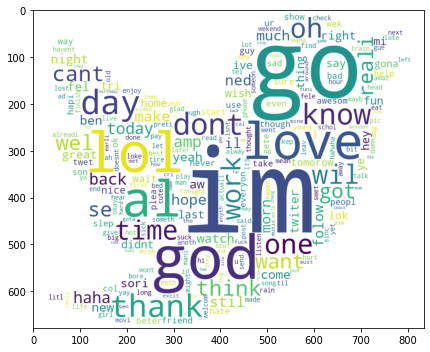

In [74]:
plt.figure(figsize=[7,22])
plt.imshow(tot_wc)


In [75]:
def get_words(ds):

    # pos = ds[~mask]
    # print(pos.head(1))
    pos = ds[~mask][ds['sentiment']== 1]
    neg = ds[~mask][ds['sentiment']== 0]

    return pos, neg

pos, neg = get_words(dev_ds)

<ipython-input-75-a291e8090fc4>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos = ds[~mask][ds['sentiment']== 1]
<ipython-input-75-a291e8090fc4>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg = ds[~mask][ds['sentiment']== 0]


In [76]:
pos_wc = WordCloud(max_words=500, width = 3980 , height = 2080,mask=mask_tw, background_color="white",
               collocations=False).generate(" ".join(pos['stemmed'].str.join(' ')))

In [77]:
neg_wc = WordCloud(max_words=500, width = 3980 , height = 2080,mask=mask_tw, background_color="white",
               collocations=False).generate(" ".join(neg['stemmed'].str.join(' ')))

In [118]:
pos_wc.to_file('./imgs/pos_w.png')
neg_wc.to_file('./imgs/neg_w.png')

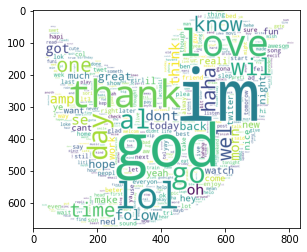

In [116]:
plt.imshow(pos_wc)

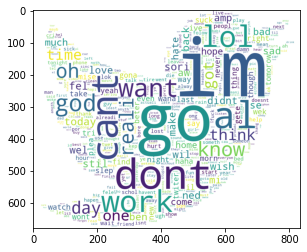

In [117]:
plt.imshow(neg_wc)

In [80]:

pos_words = list(pos_wc.words_.items())

In [81]:
neg_words = list(neg_wc.words_.items())

In [82]:
pos_words[:10]

[('im', 1.0),
 ('god', 0.9091671751067725),
 ('thank', 0.7810402684563759),
 ('love', 0.7433648566198902),
 ('lol', 0.699816961561928),
 ('go', 0.650777913361806),
 ('day', 0.5658938377059183),
 ('al', 0.5305826723611958),
 ('wil', 0.4176327028676022),
 ('know', 0.4069554606467358)]

In [83]:
neg_words[:10]


[('im', 1.0),
 ('go', 0.628168612930789),
 ('dont', 0.4708060381657647),
 ('cant', 0.38550270578182855),
 ('al', 0.378311022500712),
 ('work', 0.3511819994303617),
 ('lol', 0.3425662204500142),
 ('want', 0.33658501851324407),
 ('god', 0.3224864710908573),
 ('know', 0.32184562802620337)]

In [84]:
tf = TfidfVectorizer(ngram_range=(1,3),
                     min_df=0.001,
                     tokenizer=dummy,
                     preprocessor=dummy)
tfidf = tf.fit_transform(dev_ds['stemmed'])

In [85]:
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=tf.get_feature_names())
df_tfidf.shape

(299993, 1166)

In [86]:
missing_data = dev_ds[[ 'month', 'day', 'part_of_day', 'encoded_usr', 'len_tweet']]
missing_data['sent_pos_neg'] = dev_ds['sentiment']

datasets = [missing_data, df_tfidf]
fin_df = pd.concat(datasets, axis=1)

<ipython-input-86-17d38af40999>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['sent_pos_neg'] = dev_ds['sentiment']


In [87]:
tr = fin_df[~mask]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(tr.drop(columns=['sent_pos_neg']), tr[['sent_pos_neg']],
                                                    test_size=0.1, random_state=42, stratify=True)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((202494, 1171), (22500, 1171), 202494, 22500)

In [89]:
def build_classifier(X_train, y_train, X_test, y_test, clf_to_evaluate, score, param_grid, n_folds=3 ):

    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(clf_to_evaluate, param_grid, cv=n_folds, scoring=score, verbose=3, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y_test, clf.predict(X_test)

    rep = classification_report(y_true, y_pred)

    return clf, rep

In [95]:
score = 'f1_macro'

# adapt for different tests
min_sample_split = [2, 4, 5]
max_features = ['sqr', 'log2']
n_estimators = [50, 200, 300]
n_estimators_grad = [25, 50, 150]
learning_rate = [0.5, 0.9, 1]
max_depth = [100, 150, 200, 250 ]

p_grid_gaussian = {
    }
p_grid_svc = {
    'C': [0.00001, 0.0001, 0.001, 0.01]
    }
p_grid_tree = {
    # 'min_sample_split': min_sample_split,
    'max_features': max_features,
    # 'n_estimators': n_estimators,
    'max_depth': max_depth
    }
p_grid_forest = {
    # 'min_sample_split': min_sample_split,
    # 'max_features': max_features,
    'n_estimators': n_estimators,
    'max_depth': max_depth
    }
p_grid_grad = {
    'n_estimators': n_estimators_grad,
    'learning_rate': learning_rate
    }

grids = [p_grid_gaussian, p_grid_svc, p_grid_tree, p_grid_forest, p_grid_grad]

names =[
    'Naive Bayes classifier',
    'Support Vector Machine',
    'Tree Classifier',
    'Random Forest',
    'Gradient Boosting Classifier',
    ]

In [96]:
model_1 = GaussianNB() # Naive Bayes classifier//
model_2 = LinearSVC() # support vector machine
model_3 = DecisionTreeClassifier()
model_4 = RandomForestClassifier()
model_5 = GradientBoostingClassifier()

models = [model_1, model_2, model_3, model_4, model_5]

In [97]:
t = PrettyTable()
t.field_names = ['model', 'F1_score']




In [93]:
import time

time.time()

1641689135.7670758

In [98]:
for name, p_grid, model in zip(names, grids, models):
    start = time.time()
    m, sco = build_classifier(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, clf_to_evaluate=model,
                              score=score, param_grid=p_grid)

    t.add_row([name, sco])
    models.append(m)
    print((time.time()-start)/60, '\n \n \n')
    print(t)

# Tuning hyper-parameters for f1_macro
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters set found on development set:
{}
0.719 (+/-0.003) for {}
Detailed classification report:
0.3024027665456136 
 
 

+------------------------+-------------------------------------------------------+
|         model          |                        F1_score                       |
+------------------------+-------------------------------------------------------+
| Naive Bayes classifier |               precision    recall  f1-score   support |
|                        |                                                       |
|                        |          0.0       0.64      0.79      0.71      9507 |
|                        |          1.0       0.82      0.67      0.74     12993 |
|                        |                                                       |
|                        |     accuracy                           0.72     22500 |
|                        

C:\Users\Ooweey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ooweey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72503405 0.74774138 0.79798821        nan]
  warnings.warn(
C:\Users\Ooweey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ooweey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0

MemoryError: Unable to allocate 1.17 GiB for an array with shape (1168, 134996) and data type float64

In [100]:
m = models[9]

In [101]:
ev = fin_df[mask].reset_index().drop(columns=['sent_pos_neg', 'index'])
predicted_values = m.predict(ev)

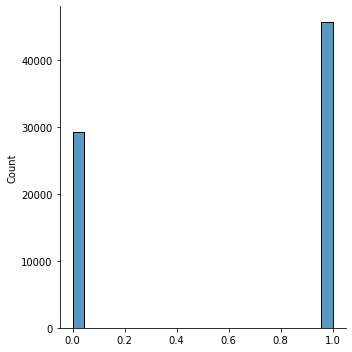

In [119]:
sns.displot(predicted_values).savefig('./imgs/predicted_distr.png')

In [ ]:
pmask = predicted_values == 1
pps = predicted_values[pmask]
pns = predicted_values[~pmask]

In [110]:
print((len(pps)/len(predicted_values)) * 100)
print((len(pns)/len(predicted_values)) * 100)


60.930145735276476
39.06985426472353


In [ ]:
# pd.DataFrame(predicted_values, index=ev.index).to_csv("s280230_eval.csv", index_label="Id", header=["Predicted"])